In [1]:
# Written 9/14/16
# This notebook is a cleaned up version of 2016-09-10-graduation-years_ravi
# This calculates statistics related to graduation years and performs K-means clustering of different trends.

In [2]:
import numpy as np
import pandas as pd
from sklearn import *
from scipy.stats import *
from framework.data import *
from framework.draw import *
from matplotlib import pyplot as plt

/home/ravirao/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/home/ravirao/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [3]:
data = pd.read_sql('''
select `Graduation year`, `Primary specialty`,
  `Total Performance Score`
from hospital_practitioners
where `Graduation year` > 1960;
''', sql)

In [551]:
data.shape

(1154554, 3)

In [372]:
# Now determine the max graduation year (most recent)
max_graduation_year = data['Graduation year'].max()

In [373]:
# create bins for every 1 years, starting at 1960 going up to 2015
# This will standardize my feature vector dimensions
my_bins_1_years = np.arange(1960, 2015, 1);
# my_bins_1_years

In [374]:
# http://stackoverflow.com/questions/6260055/in-matplotlib-how-do-you-draw-r-style-axis-ticks-that-point-outward-from-the-ax

from matplotlib import rcParams
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

In [375]:
###################################################################################################

In [376]:
# I should actually increase the length of the count vector, and add a zero towards the end.
# That means there will be a zero count for the last year.
# I suppose this relates to the interpretation of the histogram bins.
# Bin 1 is the count between 1960 and 1961, etc.

In [377]:
# This is to check that the feature matrix is correct.
# graduation_hist_df

In [378]:
#Note: in the following, use all_specialties and do not plot.

# Create histograms for the number of graduates in each year by specialty.
# Plot these, and also use them for K-Means clustering later.

# create bins for every 1 years, starting at 1960 going up to 2015
# This will standardize my feature vector dimensions
my_bins_1_years = np.arange(1960, 2015, 1);
my_bins_1_years

all_specialties = data['Primary specialty'].unique();
# all_specialties

# target_specialties = ['INTERNAL MEDICINE', 'FAMILY PRACTICE', 'NURSE PRACTITIONER', 'CERTIFIED REGISTERED NURSE ANESTHETIST'];

# If you want to use all specialties, uncomment the following line
target_specialties = all_specialties

plot_flag = 0

num_specialties = len(target_specialties)

# 2-d array of the right size filled with zeros. We will turn it into a dataframe.
graduation_hist_df = pd.DataFrame(np.zeros(shape= (len(my_bins_1_years),num_specialties)),index=my_bins_1_years,
                                  columns=list(target_specialties));

for specialty, ind in data.groupby('Primary specialty').groups.items():
    if specialty in target_specialties:
        # data.ix[ind, 'Graduation year'].hist()

        counts, bins = np.histogram(data.ix[ind, 'Graduation year'], my_bins_1_years);
               
        # save this in the large feature matrix (dataframe)
        # graduation_hist_df[specialty] = counts
        # Make sure you add a zero at the end of "counts" to match all the dimensions.
        graduation_hist_df[specialty] = np.append(counts, 0)

        if plot_flag:
            plt.clf()
            # plt.bar(bins[:-1], counts/sum(counts), width=1)
            plt.bar(bins[:-1], counts, width=1)

            # http://stackoverflow.com/questions/14705904/matplotlib-ticks-thickness
            # width=2 gives the right thickness    
            ax = plt.gca()
            ax.tick_params(width=2)

            # http://stackoverflow.com/questions/6260055/in-matplotlib-how-do-you-draw-r-style-axis-ticks-that-point-outward-from-the-ax
            ax.tick_params(axis='x', direction='out')

            plt.xlabel('Graduation Year')
            plt.ylabel('Count')
            plt.title(specialty)

            figname = specialty + '_graduation_hist.png'
            # replace whitespace in the figname with underscore
            figname = figname.replace(' ', '_')  

            plt.savefig(figname, bbox_inches='tight')
            plt.show()
            
# Drop the last two specialties -- "SINGLE OR MULTISPECIALTY" and "UNDEFINED NON...
graduation_hist_df.drop(graduation_hist_df.columns[[num_specialties - 1, num_specialties - 2]], axis=1, inplace=True) 

In [379]:
# convert elements of dataframe into 2d numpy array.

# http://pandas.pydata.org/pandas-docs/stable/cookbook.html
# df = pd.DataFrame({'AAA' : [4,5,6,7], 'BBB' : [10,20,30,40],'CCC' : [100,50,-30,-50]});
# df

# Note: the above retains the header and the graduation years. That is not what we want.
# http://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array-preserving-index
all_feature_vectors = graduation_hist_df.values

# The above is correct. Take the transpose
all_feature_vectors = all_feature_vectors.transpose()
all_feature_vectors.shape

(74, 55)

In [380]:
# So there are 74 specialties, and a 55-dimensional feature vector for each.

In [381]:
# Now run Kmeans on this.
# see README.ppt in C:\Users\ravirao\Documents\misc\info\Software_packages\Scikit
from sklearn.cluster import KMeans

In [382]:
# KMeans?

In [383]:
nsamples, n_features = all_feature_vectors.shape
print(nsamples, n_features)

74 55


In [384]:
print(all_feature_vectors[0])

[  0  10   6  12  21  22  29  37  68  48  65  62  72  85  65  78  79 116
 123 101 146 209 228 202 207 261 234 286 232 276 254 258 226 221 206 262
 168 151 129 226 187 254 206 249 208 240 230 242 258 129   2   4   5   4
   0]


In [385]:
k_means = KMeans(n_clusters=5, random_state=0) #Fixing the RNG in KMeans

In [386]:
k_means.fit(all_feature_vectors)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=0, tol=0.0001,
    verbose=0)

In [387]:
result = k_means.fit(all_feature_vectors)

In [388]:
# print(result.cluster_centers_)

In [389]:
print(result.labels_)

[0 2 2 1 4 3 1 2 2 4 3 2 0 2 2 4 2 4 4 0 2 2 0 0 0 0 2 0 2 2 0 0 0 0 0 0 2
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [390]:
# Maybe use 7 clusters instead
k_means = KMeans(n_clusters=7, random_state=0) #Fixing the RNG in KMeans
result = k_means.fit(all_feature_vectors)
print(result.labels_)

[0 6 6 5 2 3 1 6 6 2 4 6 0 6 6 2 6 2 2 0 6 6 0 6 0 0 6 0 6 6 0 0 0 0 0 0 6
 0 0 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [391]:
# Finally, we should drop that last point, at 2014 which is 0


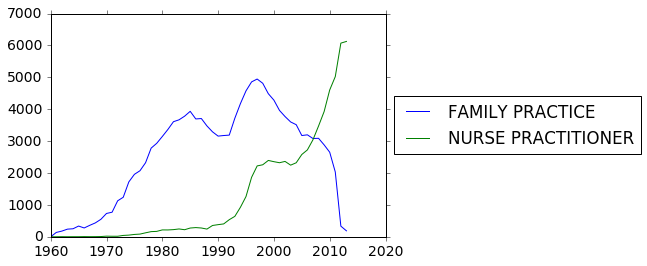

In [392]:
# http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

# http://matplotlib.org/users/legend_guide.html
# Place a legend to the right

# Now plot all those curves 
# First, check if 2-4 histograms can be shown together.
plt.clf()
plt.plot(graduation_hist_df.ix[my_bins_1_years[0:len(my_bins_1_years)-1], 'FAMILY PRACTICE'])
plt.plot(graduation_hist_df.ix[my_bins_1_years[0:len(my_bins_1_years)-1], 'NURSE PRACTITIONER'])
# Place a legend to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


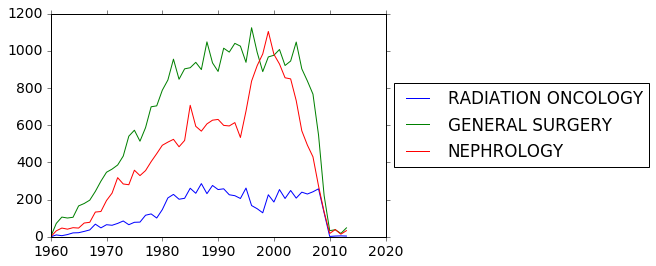

In [393]:
# http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

# http://matplotlib.org/users/legend_guide.html
# Place a legend to the right

# Now plot all those curves 
plt.clf()

for i in [0, 1, 2]:
    plt.plot(graduation_hist_df.ix[my_bins_1_years[0:len(my_bins_1_years)-1], i])
    # Place a legend to the right

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [394]:
# The above plot shows that perhaps I should normalize all the feature values. Come to that later.

Last specialty plotted = 


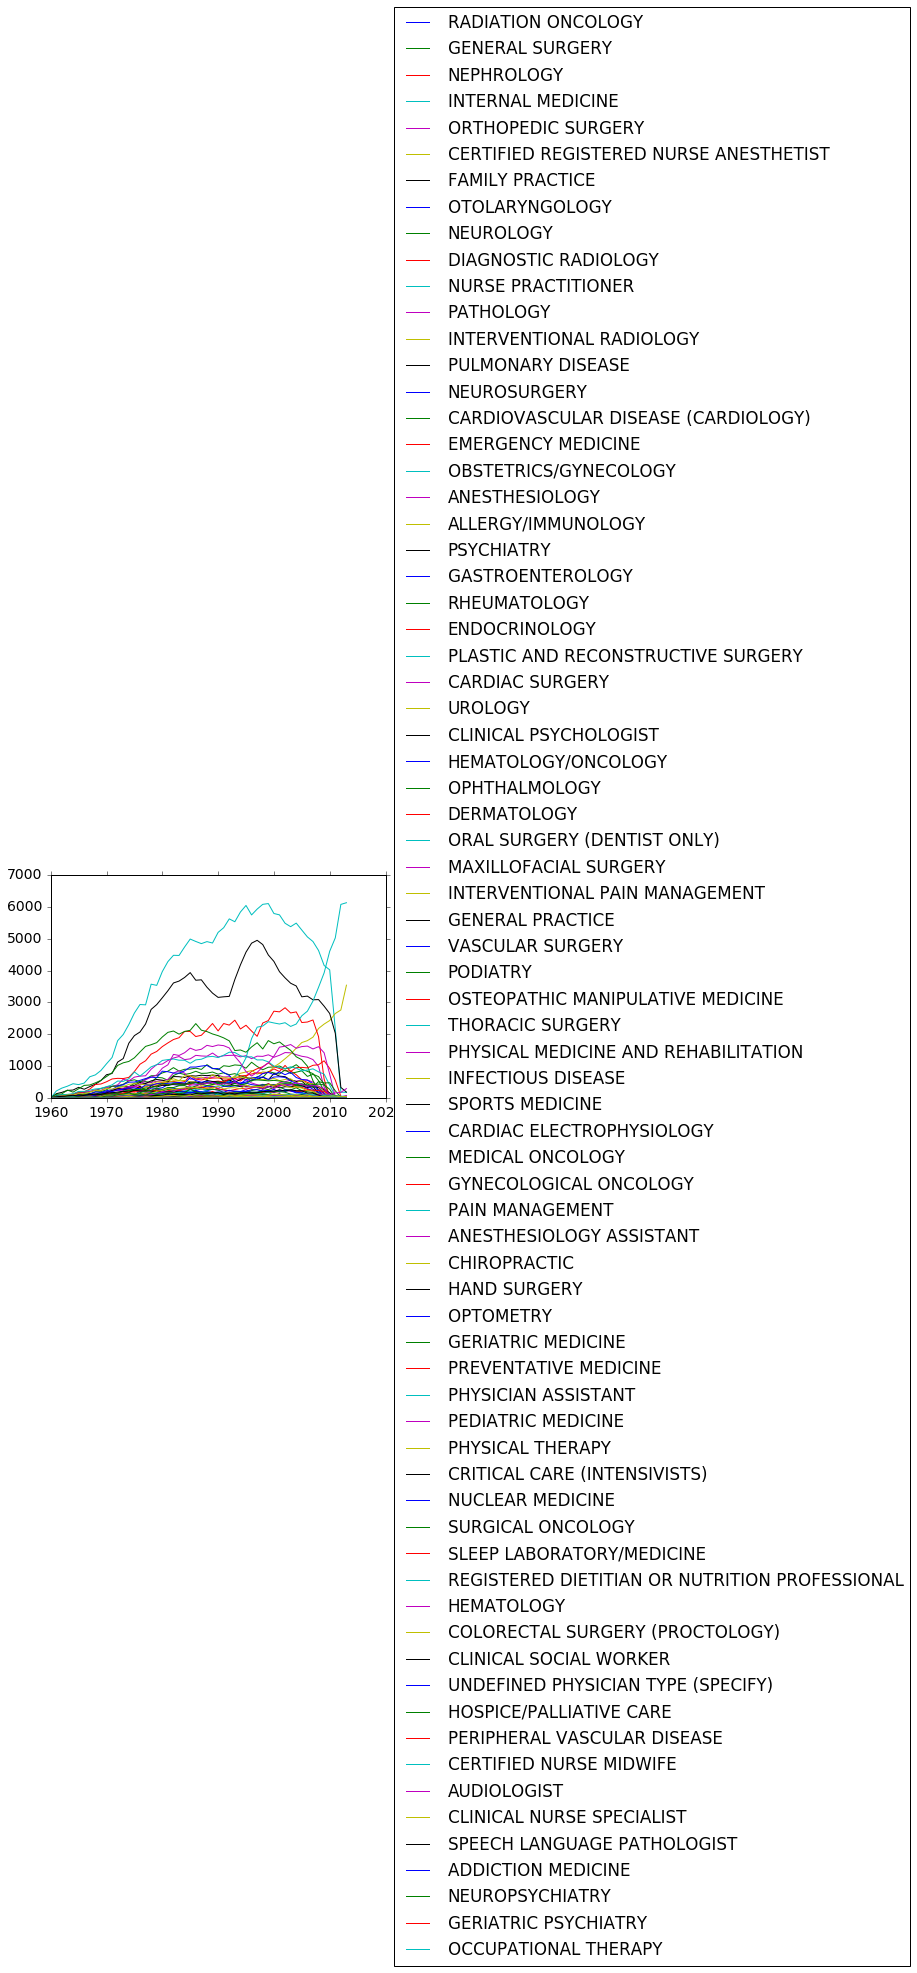

In [395]:
# http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

# http://matplotlib.org/users/legend_guide.html
# Place a legend to the right

# Now plot all those curves 
plt.clf()

nrows, ncols = graduation_hist_df.shape

for i in np.arange(ncols):
    plt.plot(graduation_hist_df.ix[my_bins_1_years[0:len(my_bins_1_years)-1], i])
    # print('Plotted i =', str(i))
    # Place a legend to the right

print('Last specialty plotted = ', )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [396]:
# graduation_hist_df.columns.values

In [397]:
# 9/14/16: Normalize the data next

In [398]:
# This code normalizes the different count vectors.
# The histogram produced is called graduation_hist_df_normalized

#Note: in the following, use all_specialties and do not plot.

# Create histograms for the number of graduates in each year by specialty.
# Plot these, and also use them for K-Means clustering later.

# create bins for every 1 years, starting at 1960 going up to 2015
# This will standardize my feature vector dimensions
my_bins_1_years = np.arange(1960, 2015, 1);
my_bins_1_years

all_specialties = data['Primary specialty'].unique();
# all_specialties

# target_specialties = ['INTERNAL MEDICINE', 'FAMILY PRACTICE', 'NURSE PRACTITIONER', 'CERTIFIED REGISTERED NURSE ANESTHETIST'];

# If you want to use all specialties, uncomment the following line
target_specialties = all_specialties

plot_flag = 0

num_specialties = len(target_specialties)

# 2-d array of the right size filled with zeros. We will turn it into a dataframe.
graduation_hist_df_normalized = pd.DataFrame(np.zeros(shape= (len(my_bins_1_years),num_specialties)),index=my_bins_1_years,
                                  columns=list(target_specialties));

for specialty, ind in data.groupby('Primary specialty').groups.items():
    if specialty in target_specialties:
        # data.ix[ind, 'Graduation year'].hist()

        counts, bins = np.histogram(data.ix[ind, 'Graduation year'], my_bins_1_years);
        
        # Normalize the counts
        counts = counts/sum(counts)
               
        # save this in the large feature matrix (dataframe)
        # graduation_hist_df[specialty] = counts
        # Make sure you add a zero at the end of "counts" to match all the dimensions.
        graduation_hist_df_normalized[specialty] = np.append(counts, 0)

        if plot_flag:
            plt.clf()
            # plt.bar(bins[:-1], counts/sum(counts), width=1)
            plt.bar(bins[:-1], counts, width=1)

            # http://stackoverflow.com/questions/14705904/matplotlib-ticks-thickness
            # width=2 gives the right thickness    
            ax = plt.gca()
            ax.tick_params(width=2)

            # http://stackoverflow.com/
            # questions/6260055/in-matplotlib-how-do-you-draw-r-style-axis-ticks-that-point-outward-from-the-ax
            ax.tick_params(axis='x', direction='out')

            plt.xlabel('Graduation Year')
            plt.ylabel('Count')
            plt.title(specialty)

            figname = specialty + '_graduation_hist.png'
            # replace whitespace in the figname with underscore
            figname = figname.replace(' ', '_')  

            plt.savefig(figname, bbox_inches='tight')
            plt.show()
            
# Drop the last two specialties -- "SINGLE OR MULTISPECIALTY" and "UNDEFINED NON...
graduation_hist_df_normalized.drop(graduation_hist_df_normalized.columns[[num_specialties - 1, num_specialties - 2]],
                                   axis=1, inplace=True) 


In [399]:
# Plot all the normalized curves now

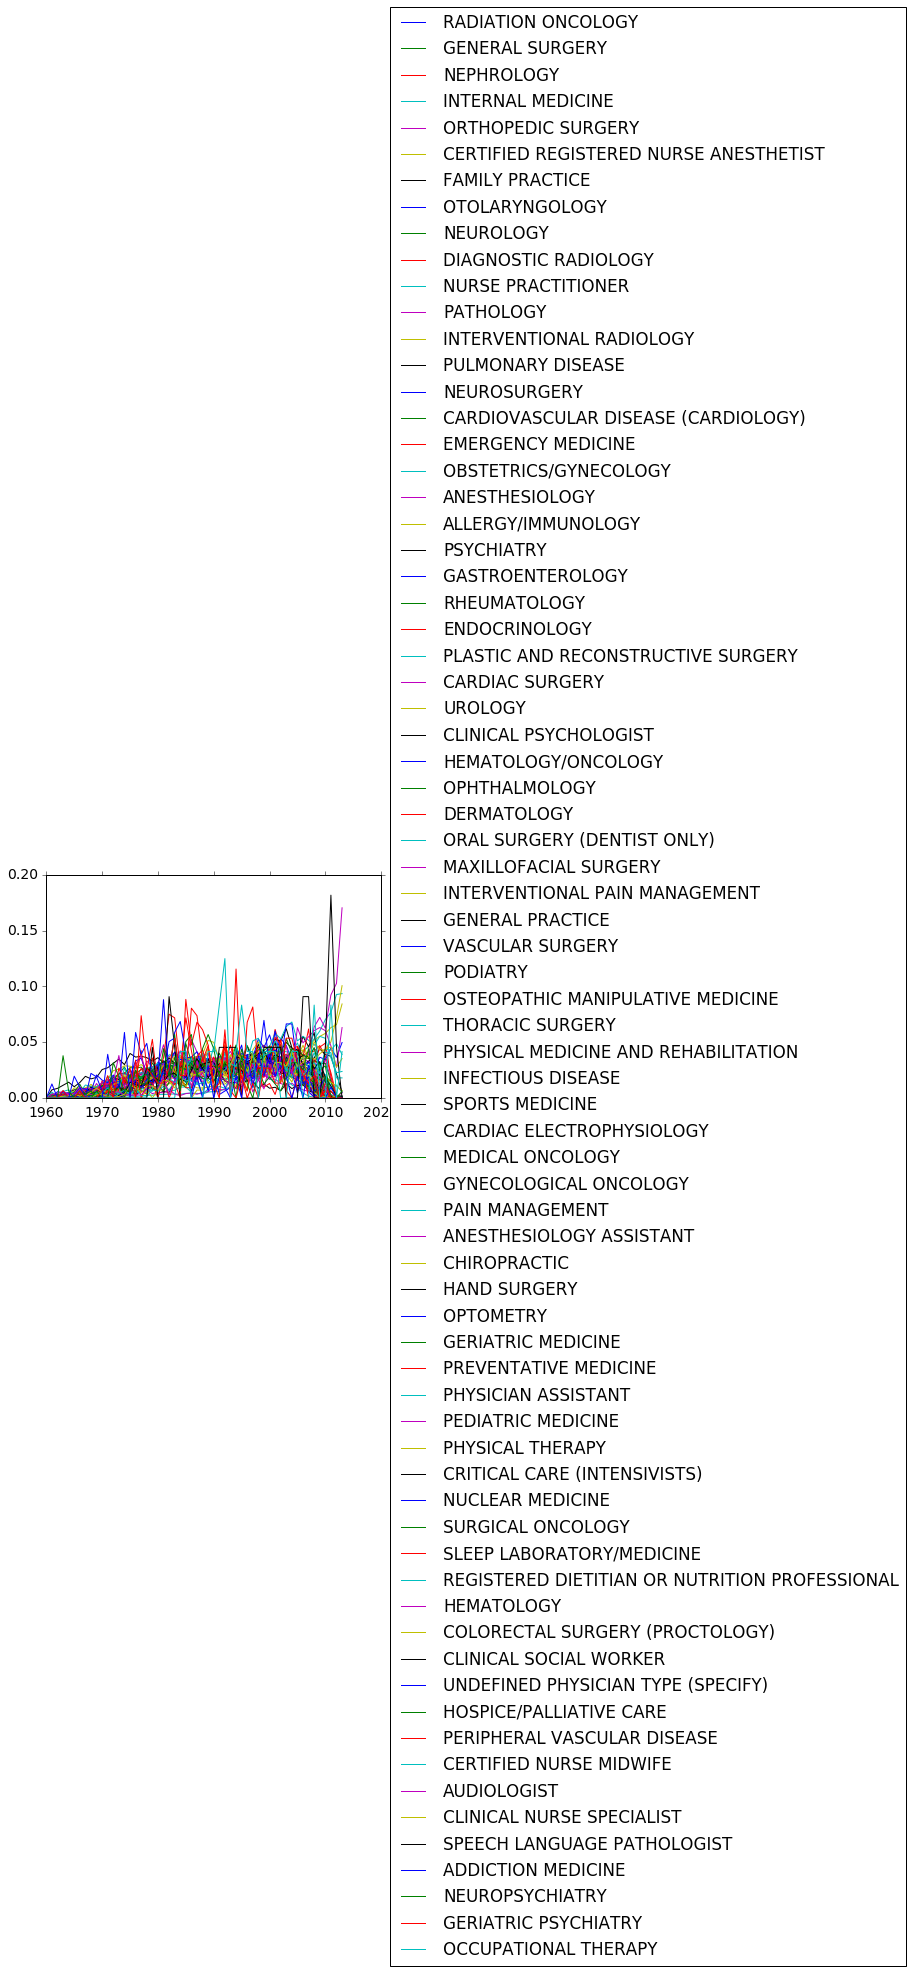

In [400]:
# http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

# http://matplotlib.org/users/legend_guide.html
# Place a legend to the right

# Now plot all those curves 
plt.clf()

nrows, ncols = graduation_hist_df_normalized.shape

for i in np.arange(ncols):
    plt.plot(graduation_hist_df_normalized.ix[my_bins_1_years[0:len(my_bins_1_years)-1], i])
    # print('Plotted i =', str(i))
    # Place a legend to the right

# print('Last specialty plotted = ', )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [401]:
# convert elements of dataframe into 2d numpy array.

# http://pandas.pydata.org/pandas-docs/stable/cookbook.html
# df = pd.DataFrame({'AAA' : [4,5,6,7], 'BBB' : [10,20,30,40],'CCC' : [100,50,-30,-50]});
# df

# Note: the above retains the header and the graduation years. That is not what we want.
# http://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array-preserving-index
all_feature_vectors = graduation_hist_df_normalized.values

# The above is correct. Take the transpose
all_feature_vectors = all_feature_vectors.transpose()
all_feature_vectors.shape

nsamples, n_features = all_feature_vectors.shape
print(nsamples, n_features)

74 55


In [402]:
k_means = KMeans(n_clusters=7, random_state=0) #Fixing the RNG in KMeans
result = k_means.fit(all_feature_vectors)
print(result.labels_)

[3 3 3 3 3 5 3 3 3 3 5 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 2
 2 3 3 3 2 3 3 3 3 5 3 3 2 3 3 2 3 5 3 3 3 3 2 3 3 2 3 2 0 2 2 2 1 4 3 3 6]


In [403]:
# Plot the curves in different groups.
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})
# df_result_labels

for cluster_id_number, ind in df_result_labels.groupby('cluster_id').groups.items():
    print('cluster id = ', cluster_id_number, ' ind = ', ind)


cluster id =  0  ind =  [65]
cluster id =  1  ind =  [69]
cluster id =  2  ind =  [16, 27, 36, 37, 41, 49, 52, 59, 62, 64, 66, 67, 68]
cluster id =  3  ind =  [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 42, 43, 44, 45, 47, 48, 50, 51, 53, 55, 56, 57, 58, 60, 61, 63, 71, 72]
cluster id =  4  ind =  [70]
cluster id =  5  ind =  [5, 10, 46, 54]
cluster id =  6  ind =  [73]


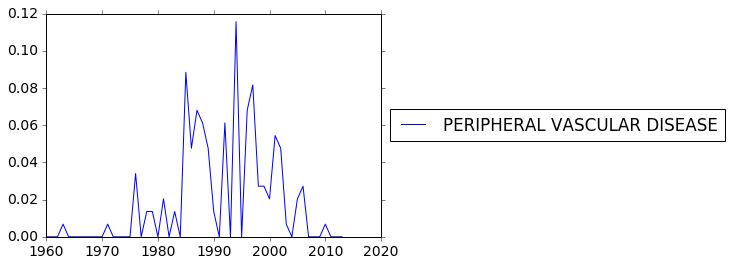

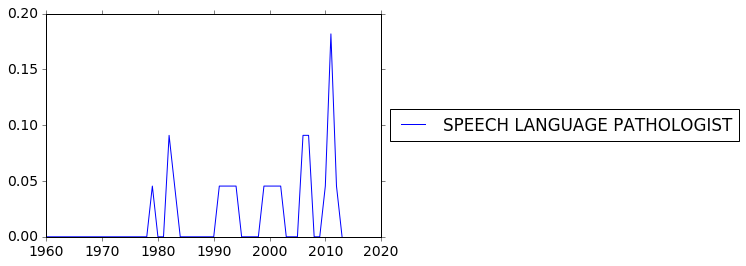

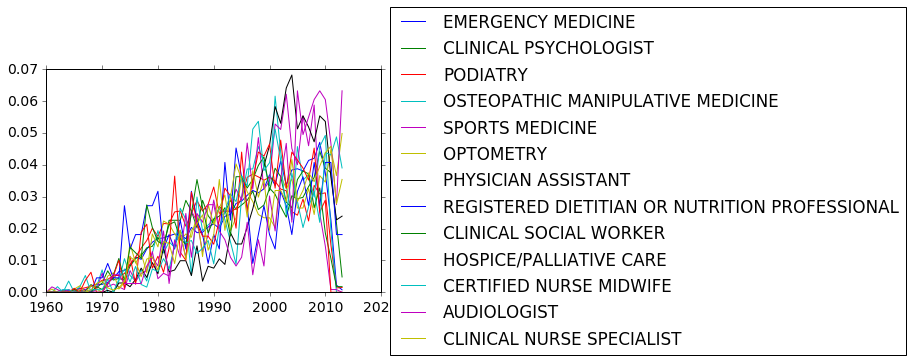

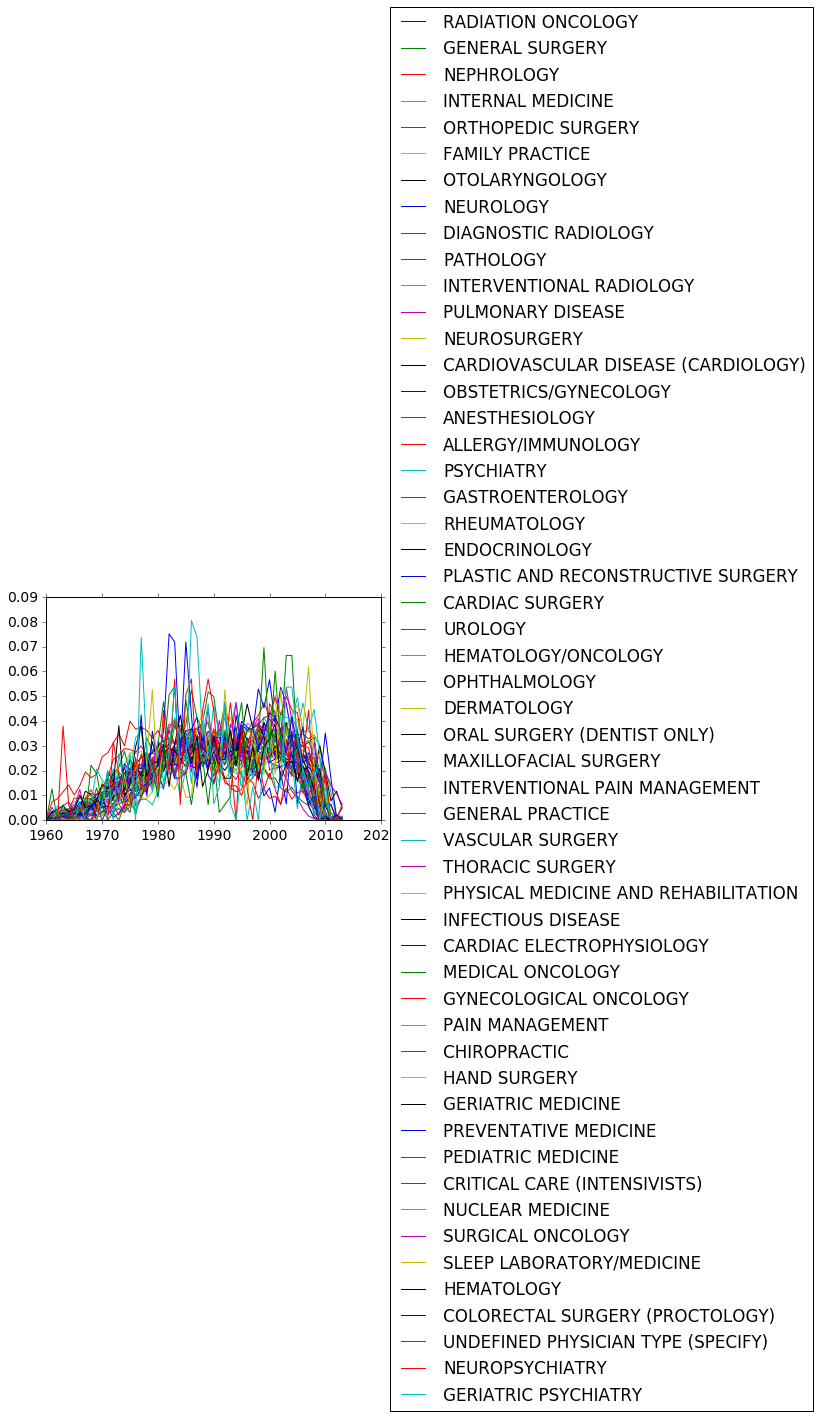

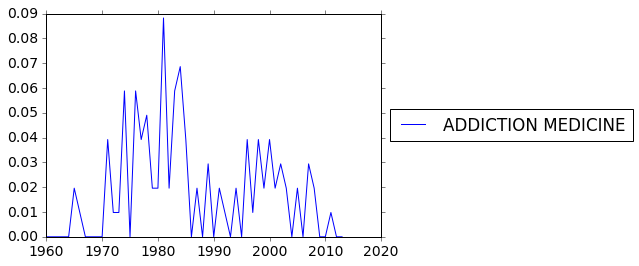

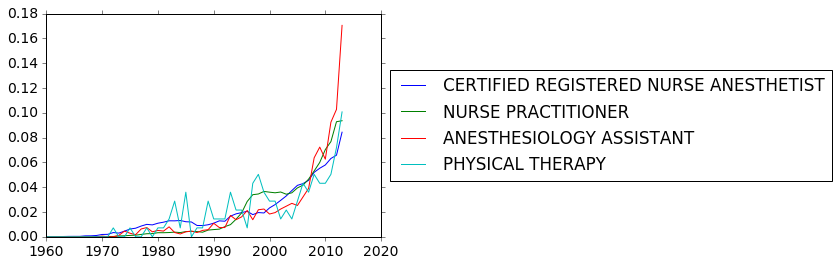

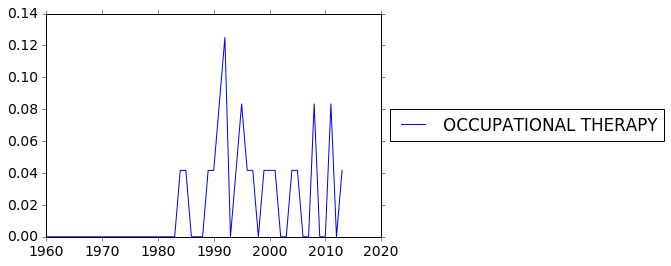

In [404]:
# Plot the curves in different groups.
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})
# df_result_labels

for cluster_id_number, ind in df_result_labels.groupby('cluster_id').groups.items():
    # print('cluster id = ', cluster_id_number, ' ind = ', ind)
    
    for i in ind:
        plt.plot(graduation_hist_df_normalized.ix[my_bins_1_years[0:len(my_bins_1_years)-1], i])
        # print('Plotted i =', str(i))
        # Place a legend to the right

    # print('Last specialty plotted = ', )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()


In [405]:
# from the above we see that there are clusters with just 1 member each.
# Treat these as outliers, convert their feature vectors to zero, and
# re-run the K-means.
# I'm doing this in order to preserve the correspondence of the specialty labels with the vectors
# they are associated with.

# Plot the curves in different groups.
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})

# df_result_labels

            
# how do we find the size of each cluster?
# http://stackoverflow.com/questions/17945247/pandas-groupby-get-size-of-a-group-knowing-its-id-from-grouper-group-info0
    
grouped_clusters = df_result_labels.groupby('cluster_id')
grouped_clusters_sizes = grouped_clusters.size()
grouped_clusters_sizes

cluster_id
0     1
1     1
2    13
3    53
4     1
5     4
6     1
dtype: int64

In [406]:
# we want to zero out all clusters with size = 1.
grouped_clusters_sizes[0]


1

In [407]:
grouped_clusters_sizes[6]

1

# 9/16/16:  I turned this into a markdown. Turn into code if you want to execute it.

# The following code is for debugging and shows that the small clusters are dropped
# from subsequent analysis.

# Plot the curves in different groups.
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})
# df_result_labels

# how do we find the size of each cluster?
# http://stackoverflow.com/questions/17945247/pandas-groupby-get-size-of-a-group-knowing-its-id-from-grouper-group-info0
    
grouped_clusters = df_result_labels.groupby('cluster_id')
grouped_clusters_sizes = grouped_clusters.size()
# grouped_clusters_sizes

all_feature_vectors = graduation_hist_df_normalized.values
all_feature_vectors = all_feature_vectors.transpose()
all_feature_vectors.shape

nsamples, n_features = all_feature_vectors.shape
print(nsamples, n_features)

for cluster_id_number, ind in df_result_labels.groupby('cluster_id').groups.items():
    # print('cluster id = ', cluster_id_number, ' ind = ', ind)
    
    if(grouped_clusters_sizes[cluster_id_number] == 1):
        print('Setting cluster number ', cluster_id_number, ' feature values to 0')
        print('This means row numbers correspond to rows in Ind = ', ind)
        # note that "ind" can contain multiple rows in general (e.g. if we look for small clusters, 
        # such cluster size of 3 or less)
        all_feature_vectors[ind] = 0
    else:
        for i in ind:
            plt.plot(graduation_hist_df_normalized.ix[my_bins_1_years[0:len(my_bins_1_years)-1], i])
            # print('Plotted i =', str(i))
            # Place a legend to the right

        # print('Last specialty plotted = ', )
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.show()


In [408]:
# 9/16/16

# The following code is for debugging and shows that the small clusters are dropped
# from subsequent analysis.

# Plot the curves in different groups.
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})
# df_result_labels

# how do we find the size of each cluster?
# http://stackoverflow.com/questions/17945247/pandas-groupby-get-size-of-a-group-knowing-its-id-from-grouper-group-info0
    
grouped_clusters = df_result_labels.groupby('cluster_id')
grouped_clusters_sizes = grouped_clusters.size()
# grouped_clusters_sizes

all_feature_vectors = graduation_hist_df_normalized.values
all_feature_vectors = all_feature_vectors.transpose()
all_feature_vectors.shape

nsamples, n_features = all_feature_vectors.shape
print(nsamples, n_features)

for cluster_id_number, ind in df_result_labels.groupby('cluster_id').groups.items():
    # print('cluster id = ', cluster_id_number, ' ind = ', ind)
    
    if(grouped_clusters_sizes[cluster_id_number] == 1):
        print('Setting cluster number ', cluster_id_number, ' feature values to 0')
        print('This means row numbers correspond to rows in Ind = ', ind)
        # note that "ind" can contain multiple rows in general (e.g. if we look for small clusters, 
        # such cluster size of 3 or less)
        all_feature_vectors[ind] = 0

# Now perform K-means clustering and show the results.


74 55
Setting cluster number  0  feature values to 0
This means row numbers correspond to rows in Ind =  [65]
Setting cluster number  1  feature values to 0
This means row numbers correspond to rows in Ind =  [69]
Setting cluster number  4  feature values to 0
This means row numbers correspond to rows in Ind =  [70]
Setting cluster number  6  feature values to 0
This means row numbers correspond to rows in Ind =  [73]


# I made this into a Markdown as running this code will change cluster info.

# Now perform K-means clustering and show the results.
k_means = KMeans(n_clusters=7, random_state=0) #Fixing the RNG in KMeans
result = k_means.fit(all_feature_vectors)
print(result.labels_)

In [409]:
# 9/16/16:
# The above shows that rows that get zeroed out still participate in some clusters.
# I should actually delete the outlier rows and then do the analysis.
# The trick is to keep the original labels intact.

In [410]:
# Let me make a list of all the rows that belong to outlier clusters
# The following code is for debugging and shows that the small clusters are dropped
# from subsequent analysis.

# Plot the curves in different groups.
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})
# df_result_labels

# how do we find the size of each cluster?
# http://stackoverflow.com/questions/17945247/pandas-groupby-get-size-of-a-group-knowing-its-id-from-grouper-group-info0
    
grouped_clusters = df_result_labels.groupby('cluster_id')
grouped_clusters_sizes = grouped_clusters.size()
# grouped_clusters_sizes

all_feature_vectors = graduation_hist_df_normalized.values
all_feature_vectors = all_feature_vectors.transpose()
all_feature_vectors.shape

nsamples, n_features = all_feature_vectors.shape
print(nsamples, n_features)

outlier_rows = []

for cluster_id_number, ind in df_result_labels.groupby('cluster_id').groups.items():
    # print('cluster id = ', cluster_id_number, ' ind = ', ind)
    
    if(grouped_clusters_sizes[cluster_id_number] == 1):
        print('Setting cluster number ', cluster_id_number, ' feature values to 0')
        print('This means row numbers correspond to rows in Ind = ', ind)
        # note that "ind" can contain multiple rows in general (e.g. if we look for small clusters, 
        # such cluster size of 3 or less)
        outlier_rows.append(ind)
        
# outlier_rows will contain something like: [[65], [69], [73]]
# this needs to be flattened.
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html

array_outlier_rows = np.array(outlier_rows)
array_outlier_rows = array_outlier_rows.flatten()

# Delete these rows now from the matrix
# Actually you need to also delete the corresponding labels (specialty names)
# So it is better to go to the original dataframe and do that as shown below
    
    
# Now perform K-means clustering and show the results.

74 55
Setting cluster number  0  feature values to 0
This means row numbers correspond to rows in Ind =  [65]
Setting cluster number  1  feature values to 0
This means row numbers correspond to rows in Ind =  [69]
Setting cluster number  4  feature values to 0
This means row numbers correspond to rows in Ind =  [70]
Setting cluster number  6  feature values to 0
This means row numbers correspond to rows in Ind =  [73]


In [411]:
array_outlier_rows = np.array(outlier_rows)
array_outlier_rows = array_outlier_rows.flatten()

# http://stackoverflow.com/questions/3877491/deleting-rows-in-numpy-array
tem = all_feature_vectors
tem2 = np.delete(tem, outlier_rows, axis=0)

In [412]:
# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
list_column_names = graduation_hist_df_normalized.columns.values.tolist()
list_column_names[0:3]

['RADIATION ONCOLOGY', 'GENERAL SURGERY', 'NEPHROLOGY']

In [413]:
list_column_names[65]

'PERIPHERAL VASCULAR DISEASE'

In [414]:
list_column_names[69]

'SPEECH LANGUAGE PATHOLOGIST'

In [415]:
list_column_names[70]

'ADDICTION MEDICINE'

In [416]:
list_column_names[73]

'OCCUPATIONAL THERAPY'

In [417]:
len(list_column_names)

74

In [418]:
array_outlier_rows

array([65, 69, 70, 73])

In [419]:
for i in array_outlier_rows:
    print(i)
    print(list_column_names[i])

65
PERIPHERAL VASCULAR DISEASE
69
SPEECH LANGUAGE PATHOLOGIST
70
ADDICTION MEDICINE
73
OCCUPATIONAL THERAPY


In [420]:
list_column_names = graduation_hist_df_normalized.columns.values.tolist()
list_column_names[70]

'ADDICTION MEDICINE'

In [421]:
type(array_outlier_rows)

numpy.ndarray

In [422]:
list_array_outlier_rows = list(array_outlier_rows)

In [423]:
type(list_array_outlier_rows)

list

In [424]:
list_array_outlier_rows

[65, 69, 70, 73]

In [426]:
# Note: we should make sure we also delete the specialty names associated with these rows
# in the dataframe. Note that the row numbers will correspond to column numbers in the dataframe.
# I'm using a copy of the original dataframe, as I want to keep the original around.
subset_graduation_hist_df_normalized = graduation_hist_df_normalized.copy()

# http://stackoverflow.com/questions/26347412/drop-multiple-columns-pandas
tem = subset_graduation_hist_df_normalized.drop(subset_graduation_hist_df_normalized.columns[list_array_outlier_rows], 
                                                                                       axis=1
                                                )
subset_graduation_hist_df_normalized = tem

In [427]:
# Now make sure those specialties are gone.

list_column_names = subset_graduation_hist_df_normalized.columns.values.tolist()

In [428]:
'ADDICTION MEDICINE' in list_column_names

False

In [429]:
'NEPHROLOGY' in list_column_names

True

In [430]:
# THe above verifies that we have deleted the entire column for the outlier specialties such as "ADDICTION MEDICINE"
# Now, run the k-means on the subset.

In [431]:
# convert elements of dataframe into 2d numpy array.

# http://pandas.pydata.org/pandas-docs/stable/cookbook.html
# df = pd.DataFrame({'AAA' : [4,5,6,7], 'BBB' : [10,20,30,40],'CCC' : [100,50,-30,-50]});
# df

# Note: the above retains the header and the graduation years. That is not what we want.
# http://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array-preserving-index
all_feature_vectors = subset_graduation_hist_df_normalized.values

# The above is correct. Take the transpose
all_feature_vectors = all_feature_vectors.transpose()
all_feature_vectors.shape

nsamples, n_features = all_feature_vectors.shape
print(nsamples, n_features)

70 55


In [432]:
k_means = KMeans(n_clusters=7, random_state=0) #Fixing the RNG in KMeans
result = k_means.fit(all_feature_vectors)
print(result.labels_)

[0 2 2 0 2 1 2 2 0 2 1 6 0 6 2 6 3 6 0 6 6 6 6 2 2 6 6 5 2 0 0 6 0 2 6 2 0
 3 6 0 2 3 2 6 2 0 1 2 2 5 2 6 3 2 1 2 6 2 0 5 6 2 0 2 3 5 5 5 6 4]


In [433]:
# Plot the curves in different groups.
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})
# df_result_labels

for cluster_id_number, ind in df_result_labels.groupby('cluster_id').groups.items():
    print('cluster id = ', cluster_id_number, ' ind = ', ind)

cluster id =  0  ind =  [0, 3, 8, 12, 18, 29, 30, 32, 36, 39, 45, 58, 62]
cluster id =  1  ind =  [5, 10, 46, 54]
cluster id =  2  ind =  [1, 2, 4, 6, 7, 9, 14, 23, 24, 28, 33, 35, 40, 42, 44, 47, 48, 50, 53, 55, 57, 61, 63]
cluster id =  3  ind =  [16, 37, 41, 52, 64]
cluster id =  4  ind =  [69]
cluster id =  5  ind =  [27, 49, 59, 65, 66, 67]
cluster id =  6  ind =  [11, 13, 15, 17, 19, 20, 21, 22, 25, 26, 31, 34, 38, 43, 51, 56, 60, 68]


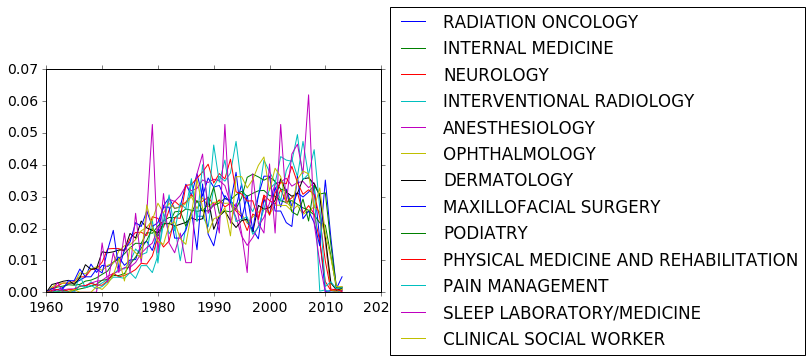

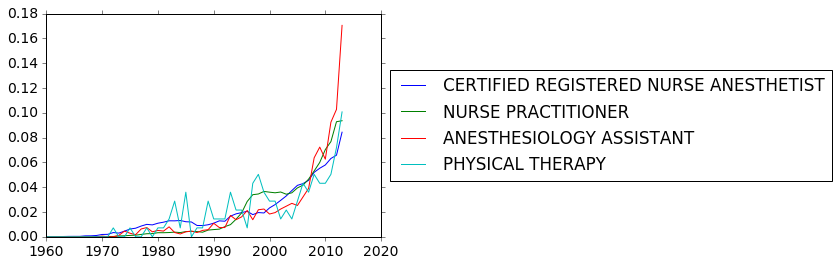

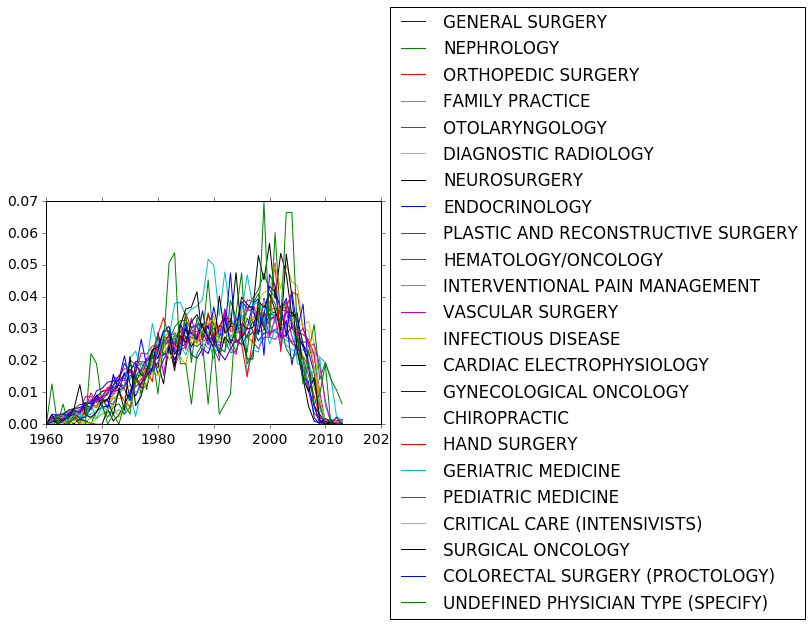

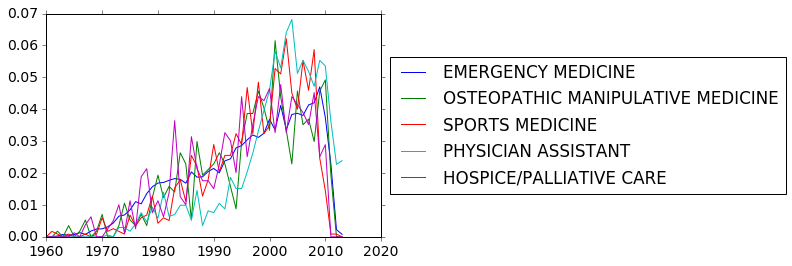

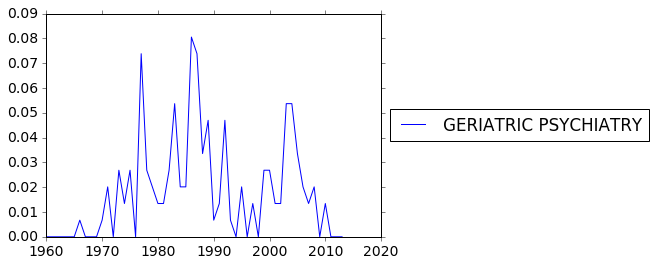

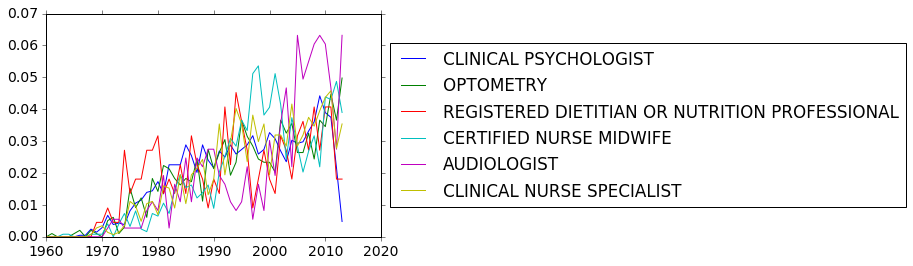

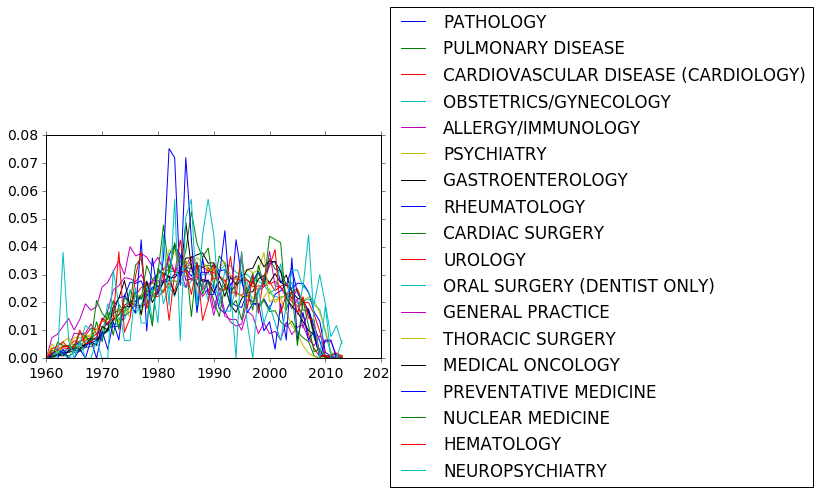

In [434]:
# Plot the curves in different groups.
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})
# df_result_labels

for cluster_id_number, ind in df_result_labels.groupby('cluster_id').groups.items():
    # print('cluster id = ', cluster_id_number, ' ind = ', ind)
    
    for i in ind:
        plt.plot(subset_graduation_hist_df_normalized.ix[my_bins_1_years[0:len(my_bins_1_years)-1], i])
        # print('Plotted i =', str(i))
        # Place a legend to the right

    # print('Last specialty plotted = ', )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()


In [499]:
# http://stackoverflow.com/questions/6260055/in-matplotlib-how-do-you-draw-r-style-axis-ticks-that-point-outward-from-the-ax

from matplotlib import rcParams
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

# http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
rcParams.update({'font.size': 14})

cluster_1_kmeans.png


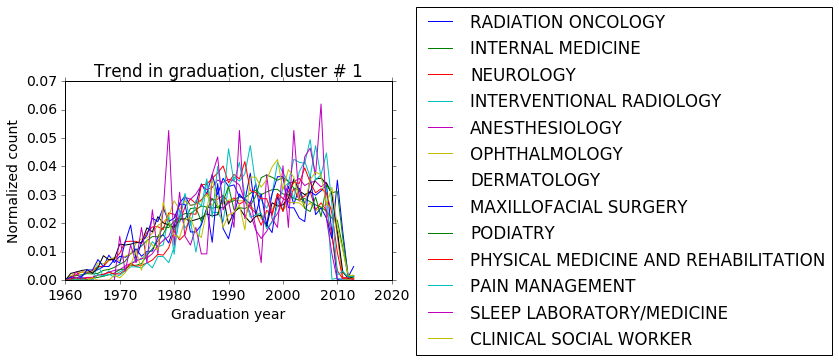

cluster_2_kmeans.png


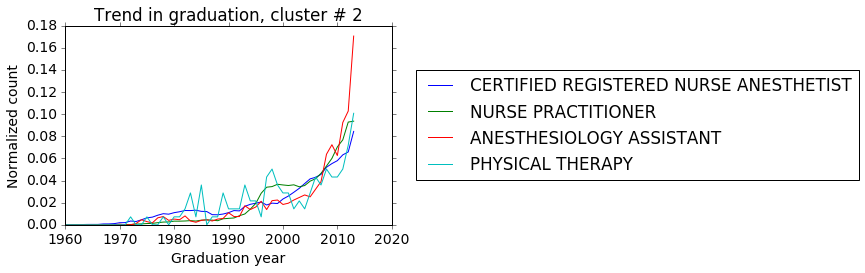

cluster_3_kmeans.png


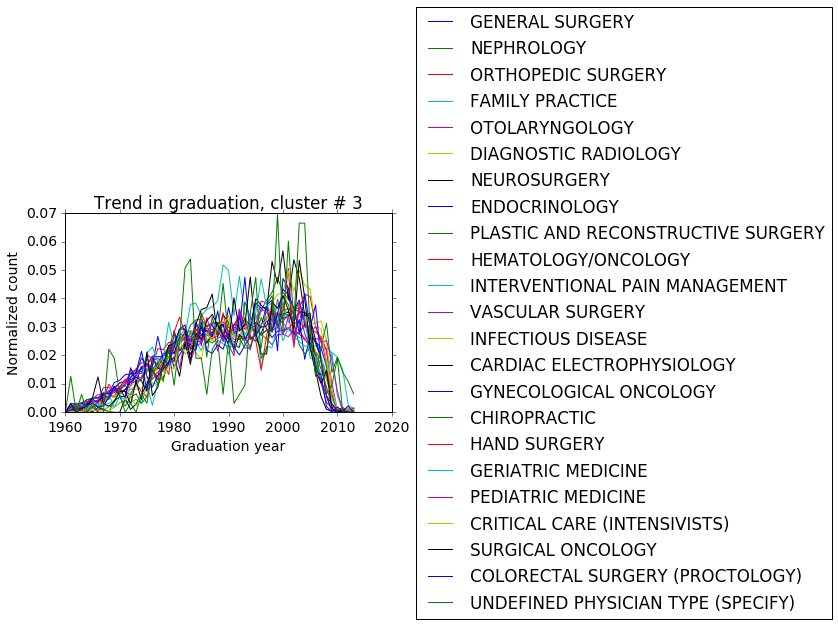

cluster_4_kmeans.png


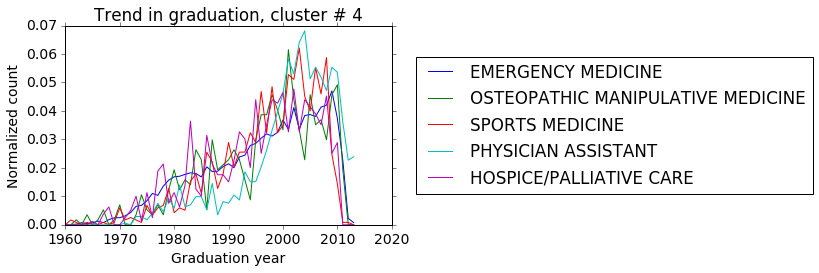

cluster_5_kmeans.png


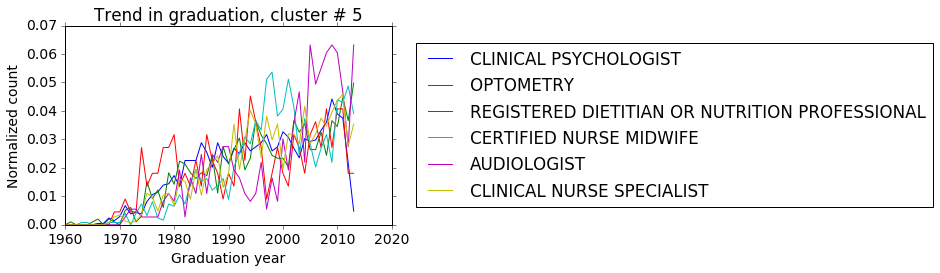

cluster_6_kmeans.png


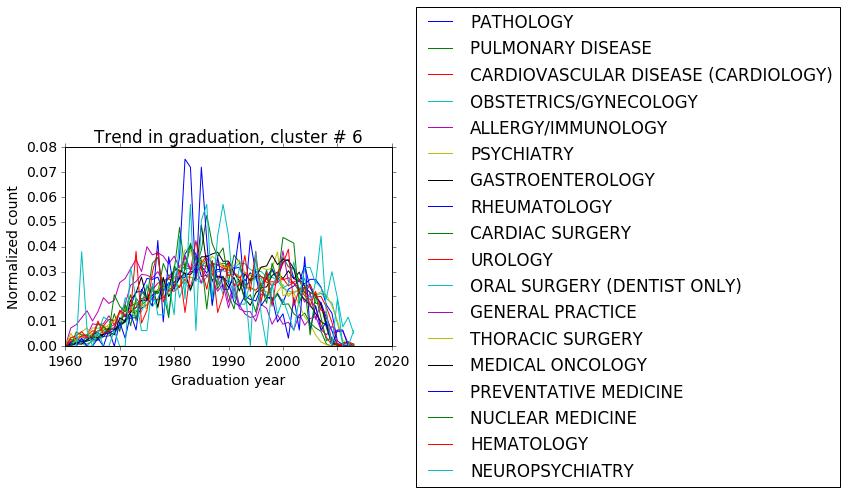

In [436]:
# Plot the curves in different groups.

# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_result_labels = pd.DataFrame({'cluster_id': result.labels_})
# df_result_labels

cluster_title_number = 1

for cluster_id_number, ind in df_result_labels.groupby('cluster_id').groups.items():
    # print('cluster id = ', cluster_id_number, ' ind = ', ind)
    
    # Do not plot single member clusters
    if(len(ind) > 1):
        for i in ind:
            plt.plot(subset_graduation_hist_df_normalized.ix[my_bins_1_years[0:len(my_bins_1_years)-1], i])
            # print('Plotted i =', str(i))
            # Place a legend to the right

        # print('Last specialty plotted = ', )
        # The argument 1.05 adds a little padding in the x direction
        # between the legend and the plot.
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        plt.xlabel('Graduation year')
        plt.ylabel('Normalized count')
        plt.title('Trend in graduation, cluster # ' + str(cluster_title_number))
                
        # Use cluster_title_number in the figname rather than cluster_id_number
        # This way, everything will be consistent.
        figname = 'cluster_' + str(cluster_title_number) + '_kmeans.png'
        cluster_title_number = cluster_title_number + 1
        
        print(figname)
        plt.tight_layout()
        
        plt.savefig(figname, bbox_inches='tight', dpi=300)
        
        plt.show()

In [ ]:
# 9/17/16
# Next, plot the cluster centers.
# Note that the cluster centers determined by K-means can be considered to be an "average" curve 
# for that cluster. I could use the mean or median count for each year. But the K-means already has its
# own version of the cluster mean.



[ 0.          0.00081168  0.00117105  0.00130727  0.0015673   0.00163198
  0.00315659  0.00315127  0.00400896  0.00414629  0.00614903  0.00679071
  0.0091386   0.00879101  0.00979369  0.01144914  0.01403023  0.01435309
  0.01774347  0.02052101  0.01809115  0.02256562  0.02364255  0.02262088
  0.02276636  0.02431354  0.02773053  0.02836813  0.03101237  0.02764475
  0.02945142  0.02893817  0.03225679  0.02810939  0.02936138  0.02682009
  0.02433927  0.02585304  0.02664893  0.0306452   0.03085861  0.03065121
  0.03366038  0.03127508  0.03173176  0.03424669  0.03206011  0.03315792
  0.02993048  0.02138694  0.01322465  0.00487583  0.00083325  0.00121517
  0.        ]


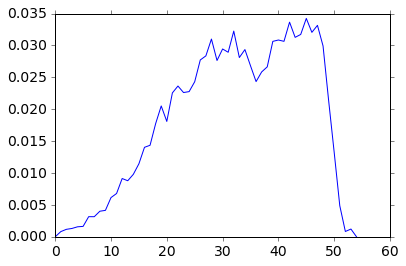

In [457]:
# For plotting: if we just use the cluster_centers_ then you lose the
# x axis labels.

print(result.cluster_centers_[0])
plt.plot(result.cluster_centers_[0])
plt.show()


In [ ]:

# So we want to create a dataframe around the cluster centers, and give the appropriate 
# column names etc.

# First we need to determine how many significant clusters there are, ie clusters
# with more than 1 member.



In [452]:
# This computes the sizes of each of the clusters found by K-means.
cluster_sizes = df_result_labels.groupby('cluster_id').size()
print(cluster_sizes)
type(cluster_sizes)

cluster_id
0    13
1     4
2    23
3     5
4     1
5     6
6    18
dtype: int64


pandas.core.series.Series

In [458]:
# we want to retain those that have more than 1 element.
significant_clusters = cluster_sizes > 1
significant_clusters

cluster_id
0     True
1     True
2     True
3     True
4    False
5     True
6     True
dtype: bool

In [460]:
# We need to count the number of 'True' elements
# http://stackoverflow.com/questions/8364674/python-numpy-how-to-count-the-number-of-true-elements-in-a-bool-array
num_significant_clusters = np.count_nonzero(significant_clusters)
num_significant_clusters


6

In [488]:
# OK. So the above is the number of dataframe columns we need.

# This was the first approach I took.
# I abandoned this as it is easier just to set up a new dataframe from scratch. See later.
# Start off with the dataframe subset_graduation_hist_df_normalized and trim this
# df_cluster_centers = subset_graduation_hist_df_normalized.copy()
# print(df_cluster_centers.shape)

# Say we have 55 rows and 70 columns.
# The 55 rows correspond to the graduation years. We will retain that.
# We just need to change the column titles.
# First delete the unneeded columns
# http://stackoverflow.com/questions/14363640/python-pandas-deleting-multiple-series-from-a-data-frame-in-one-command
# Use something like:
# # df.drop(df.columns[1:], axis=1)
# So we need: df_cluster_centers.drop(df_cluster_centers.columns[6:], axis=1)
# df_cluster_centers.drop(df_cluster_centers.columns[num_significant_clusters:], axis=1, inplace=True)
# The above will give us 6 columns.

# First, rename them
# http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
# Create the desired column titles
column_titles = [];
for i in np.arange(num_significant_clusters):
    t = 'cluster #' + str(i+1)
    column_titles.append(t)
    
print(column_titles)

# df_cluster_centers.columns = column_titles

# Now assign the cluster center vectors along the columns.
# Make sure you insert the vectors in the same order as you
# plotted earlier.



    


['cluster #1', 'cluster #2', 'cluster #3', 'cluster #4', 'cluster #5', 'cluster #6']


In [473]:
for i in significant_clusters:
    print(i)

True
True
True
True
False
True
True


In [478]:
# The following prints all the cluster centers
# print(result.cluster_centers_)


In [481]:
# Now generate the indices only of the significant clusters
# http://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list
# use np.where()
indices_signifiant_clusters = np.where(significant_clusters)
indices_signifiant_clusters

(array([0, 1, 2, 3, 5, 6]),)

In [483]:
# The following prints only the significant cluster centers
# print(result.cluster_centers_[indices_signifiant_clusters])

In [486]:
# Now assign the above significant cluster centers to the dataframe array.
# I tried the following, but it didnt work. It may be easier to create a new dataframe from scratch.
# df_cluster_centers.values = result.cluster_centers_[indices_signifiant_clusters].transpose()

# 2-d array of the right size filled with zeros. We will turn it into a dataframe.
df_cluster_centers = pd.DataFrame(result.cluster_centers_[indices_signifiant_clusters].transpose(),index=my_bins_1_years,
                                  columns=column_titles);

In [489]:
df_cluster_centers.head(3)

,cluster #1,cluster #2,cluster #3,cluster #4,cluster #5,cluster #6
1960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1961,0.000812,0.000040,0.001735,0.000357,0.000169,0.001886
1962,0.001171,0.000057,0.001437,0.000570,0.000000,0.002621


In [490]:
df_cluster_centers.tail(3)

,cluster #1,cluster #2,cluster #3,cluster #4,cluster #5,cluster #6
2012,0.000833,0.083331,0.001092,0.005164,0.030047,0.001066
2013,0.001215,0.112295,0.000862,0.004929,0.035046,0.000952
2014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


cluster #1
cluster_1_kmeans_centers.png


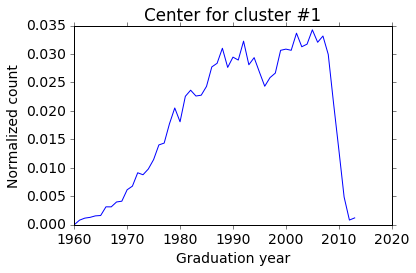

cluster #2
cluster_2_kmeans_centers.png


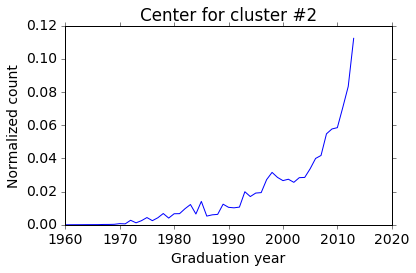

cluster #3
cluster_3_kmeans_centers.png


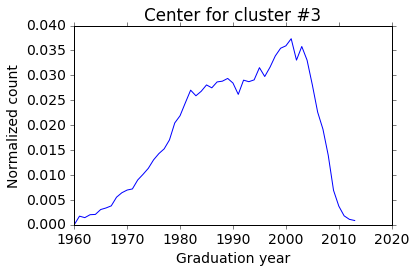

cluster #4
cluster_4_kmeans_centers.png


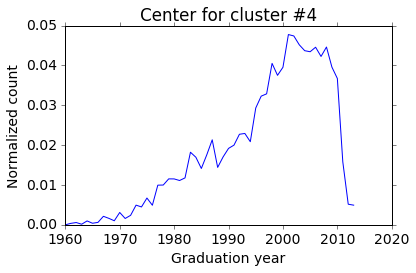

cluster #5
cluster_5_kmeans_centers.png


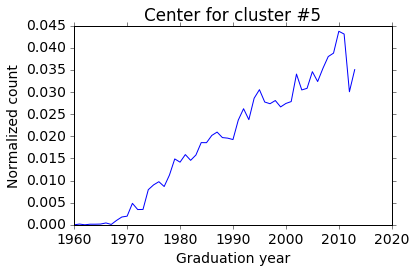

cluster #6
cluster_6_kmeans_centers.png


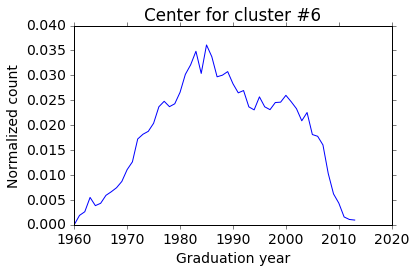

In [496]:
# 9/17/16
# The following creates separate plots for each cluster.
# Next, plot the cluster centers.
# Note that the cluster centers determined by K-means can be considered to be an "average" curve 
# for that cluster. I could use the mean or median count for each year. But the K-means already has its
# own version of the cluster mean.

# Note that I have already filtered out the significant clusters to retain them (those with > 1 members)


for col in df_cluster_centers.columns:
    print(col)
    
    plt.plot(df_cluster_centers.ix[my_bins_1_years[0:len(my_bins_1_years)-1], col])
    # print('Last specialty plotted = ', )
    # The argument 1.05 adds a little padding in the x direction
    # between the legend and the plot.
    # You dont need a legend for a single plot
    # plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.xlabel('Graduation year')
    plt.ylabel('Normalized count')
    plt.title('Center for ' + col)
                
    # Use cluster_title_number in the figname rather than cluster_id_number
    # This way, everything will be consistent.
    figname = col + '_kmeans_centers.png'
    # remove the '#' in the string
    figname = figname.replace('#', '')
    # substitute spaces with underscore, _
    figname = figname.replace(' ', '_')
        
    print(figname)
    plt.tight_layout()
        
    # plt.savefig(figname, bbox_inches='tight', dpi=300)
        
    plt.show()

 

cluster #1
cluster #2
cluster #3
cluster #4
cluster #5
cluster #6


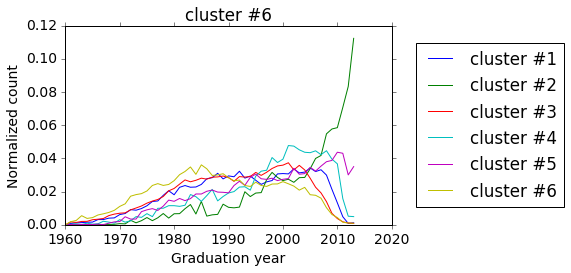

In [497]:
# 9/17/16
# The following creates a single plot for all clusters.

# Next, plot the cluster centers.
# Note that the cluster centers determined by K-means can be considered to be an "average" curve 
# for that cluster. I could use the mean or median count for each year. But the K-means already has its
# own version of the cluster mean.

# Note that I have already filtered out the significant clusters to retain them (those with > 1 members)


for col in df_cluster_centers.columns:
    print(col)
    
    plt.plot(df_cluster_centers.ix[my_bins_1_years[0:len(my_bins_1_years)-1], col])
    # print('Last specialty plotted = ', )
    # The argument 1.05 adds a little padding in the x direction
    # between the legend and the plot.

                
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.xlabel('Graduation year')
plt.ylabel('Normalized count')
plt.title(col)    
plt.tight_layout()
figname = 'all_clusters_kmeans_centers.png'      
plt.savefig(figname, bbox_inches='tight', dpi=300)
        
plt.show()

 

In [506]:

# http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
rcParams.update({'font.size': 24})

cluster #1
cluster #2
cluster #3
cluster #4
cluster #5
cluster #6


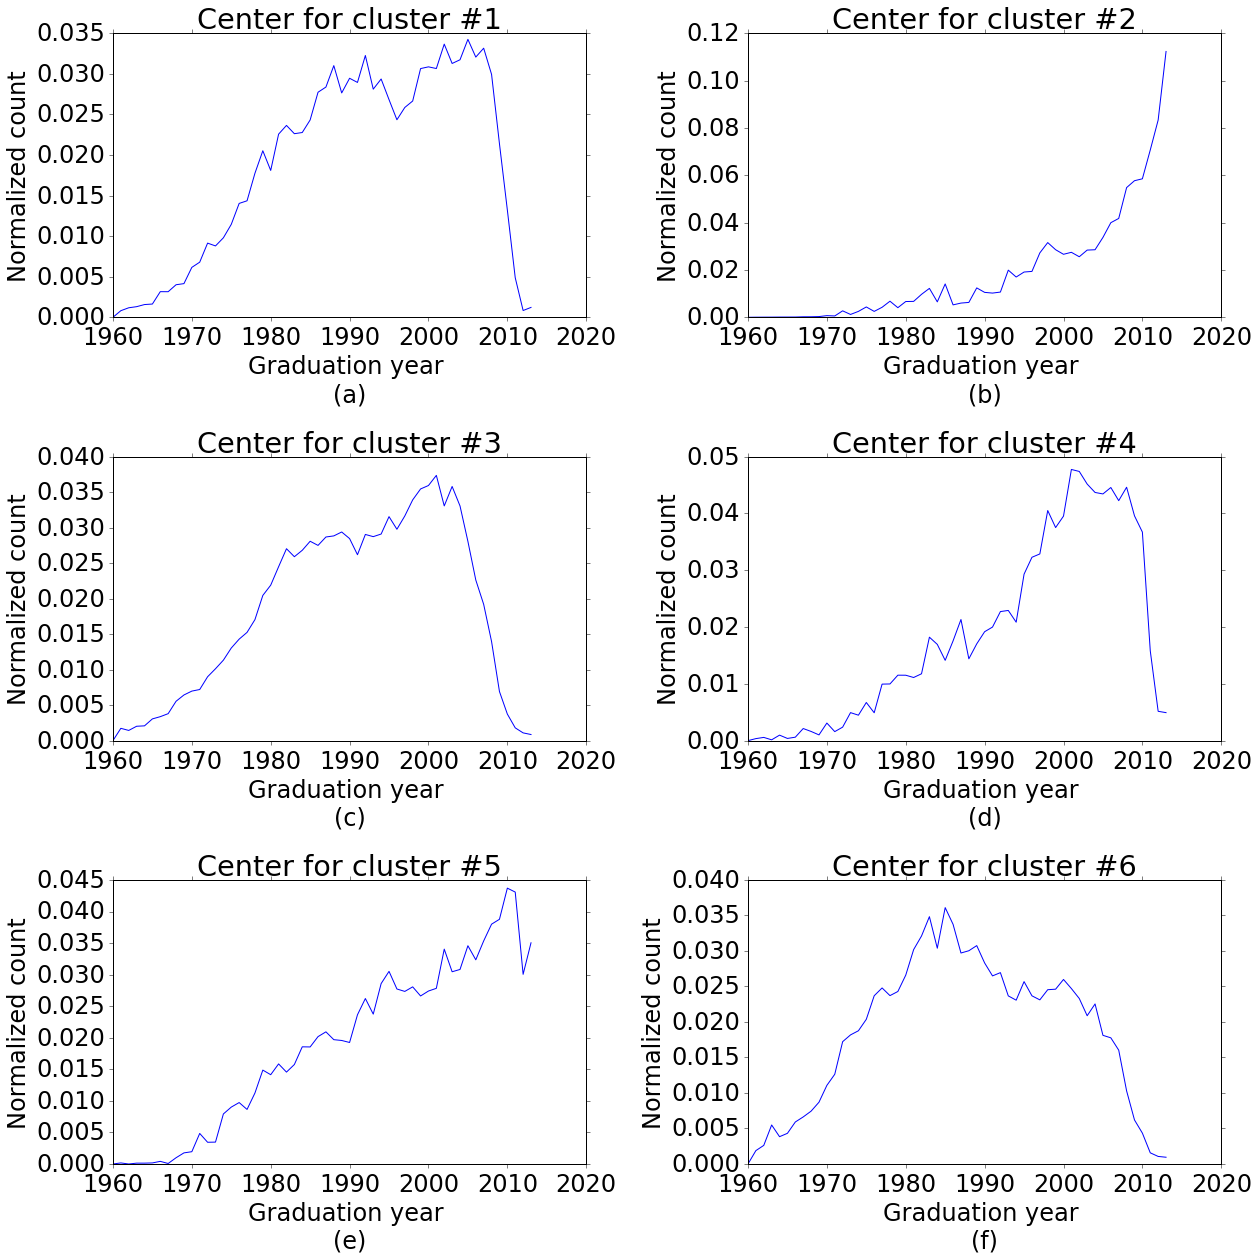

In [507]:
# 9/17/16
# The following creates 6 separate subplots, one for each cluster.
# Next, plot the cluster centers.
# Note that the cluster centers determined by K-means can be considered to be an "average" curve 
# for that cluster. I could use the mean or median count for each year. But the K-means already has its
# own version of the cluster mean.

# Note that I have already filtered out the significant clusters to retain them (those with > 1 members)

# a subplot number like 321 means: 3x2 grid and this is the first plot (#1)
# Note: we would like the ordering to be the following

sps=iter([321, 322, 323, 324, 325, 326])

subplot_labels=iter(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)'])

plt.clf()
plt.figure(figsize=(18,18))

for col in df_cluster_centers.columns:
    print(col)
    
    plt.subplot(next(sps))
    plt.plot(df_cluster_centers.ix[my_bins_1_years[0:len(my_bins_1_years)-1], col])
    # print('Last specialty plotted = ', )
    # The argument 1.05 adds a little padding in the x direction
    # between the legend and the plot.
    # You dont need a legend for a single plot
    # plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.xlabel('Graduation year \n'+ next(subplot_labels))
    plt.ylabel('Normalized count')
    plt.title('Center for ' + col)
                  

plt.tight_layout()
figname = 'all_clusters_subplotted_kmeans_centers.png'      
plt.savefig(figname, bbox_inches='tight', dpi=300)
        
plt.show()


In [508]:
subset_graduation_hist_df_normalized.shape

(55, 70)

In [ ]:
##############  Now run TSNE #################

In [545]:
X = subset_graduation_hist_df_normalized.values

# For TSNE we need each row in the matrix to be a sample.
# Currently, each column is a sample. So take the transpose.
X = X.transpose()

# from sklearn.decomposition import PCA

from sklearn import (manifold, datasets, decomposition, ensemble, lda,
                     random_projection)


# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
# t0 = time()
X_TSNE = tsne.fit_transform(X)

Computing t-SNE embedding


In [546]:
X.shape

(70, 55)

In [547]:
X_TSNE.shape

(70, 2)

In [548]:
x = X_TSNE[:, 0]
y = X_TSNE[:, 1]

# Use labels from the latest K-means analysis
cluster_id = result.labels_

In [549]:
cluster_id.shape

(70,)

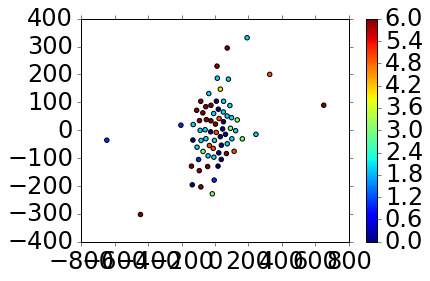

In [550]:
plt.scatter(x, y, c=cluster_id)
plt.colorbar()
plt.show()

In [ ]:
# I think a lot tweaking may be necessary to get the TSNE to work right.
# So perhaps do this later.